<a href="https://colab.research.google.com/github/cbsobral/python/blob/master/topic_choices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data
First, we saved the supervision plans that were downloaded as .pdf in .txt format.

Then, we uploaded the texts into a Google Drive, and imported them to define our corpus.


In [ ]:
# Install and update packages
#!pip install pyLDAvis
#!pip install -U gensim

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Import packages 
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
import gensim
from gensim import corpora, models
import pandas as pd
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
from matplotlib import pyplot as plt

In [ ]:
# Import supervision plans from drive
"""
This will only run with Google Drive access. To reproduce the code, the same folder can be found on the GitHub page: 
https://github.com/cbsobral/python/tree/master/data/txt_prof
"""
url = (r'/content/drive/My Drive/data/')
corpus_list = PlaintextCorpusReader(url, '.*txt')  # import all files ending in 'txt'

Before deriving the topics from our corpus, we took some text preprocessing actions:
* Stopwords removal: we exclude from the topic modeling analysis words that do not carry substantive meaning, such as “the”, “only” “not”, “own”, etc.
* Defining additional stopwords: we define additional words that, in the context of our analysis, do not add substantive value to our topic modeling. The list was constructed by running the model a few times and checking which irrelevant words kept being signaled as relevant, without being informative of a research/methodological interest. 
* Lowercasing: standardizing the words to be analyzed with all lower case characters
* Lemmatization with **WordNet**: transforms words to their root in order allow for a broader matching sample (for example, maps the word “better” as “good”). It is used as an alternative to stemming (which just removes inflections).
* Punctuation Removal

Preprocessing our corpus allows us to extract a group of topics that better represents the substantive and methodological ideas conveyed in the supervision plans. 

Our aim is to represent concepts by a sample of the most relevant keywords. Therefore, eliminating noise by removing stopwords and punctuation, and standardizing the targets – by lowercasing and lemmatization – should ultimately result in a better model.


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

wordnet = nltk.WordNetLemmatizer()
stoplist = stopwords.words('english')

# Define additional stopwords in a string
additional_stopwords = """http question impact professor school dissertation paper take following nuffield
                          title school session study work topics project partner practice happy plan see supervise
                          research thesis issue design student topic supervision university lab mia mpp org etc"""   

stoplist += additional_stopwords.split() # join both lists

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Convert token to lowercase and lemmatize using the Porter algorithm
def normalize_token(token):
  return wordnet.lemmatize(token.lower())

# Evaluate whether or not to retain `token`
def filter_token(token):
    token = token.lower()
    return token not in stoplist and token.isalpha() and len(token) > 1

Using **gensim**, we created a dictionary that contains a map of all words (tokens) present in our corpus and relates them to their unique ids. With this dictionary, we generate a “bag-of-words” corpus in which the words in the documents were replaced with their respective id (provided by the dictionary).

In [ ]:
# tokenize and apply normalize and filter functions to files
corpus=[[normalize_token(token) 
            for token in corpus_list.words(fileids=[fileid])
            if filter_token(token)]
            for fileid in corpus_list.fileids()]

# create bag of words for each document
dictionary = gensim.corpora.Dictionary(corpus)         
corpus_bow = [dictionary.doc2bow(document) for document in corpus]

## LDA Model

We employed the Latent Dirichlet Allocation (LDA) model, a generative probabilistic model, to identify the corpus topics.The model provides topic probabilities as a representation of the content of a document. The distribution of probabilities, evidently, depends on the number of topics you choose to apply in the LDA model.

We experimented with different topic numbers, ranging from 5 to 20, and found 10 to be the one that resulted in more precise recommendations. 

In [ ]:
# Run model
lda_model = gensim.models.LdaModel(corpus_bow, 
                               id2word=dictionary,
                               num_topics=10, # best results with 10 topics
                               random_state=123, # seed for consistency
                               passes=500)

### LDA Visualization
Here we can see a sample of the probability of certain words being associated with each one of the ten topics. We set the sample of words displayed to be 7. The words are listed in order of importance.

In [ ]:
# Visualize words per topic
for i, topic in enumerate(lda_model.print_topics(num_topics=10, num_words=7)):
    print (i, ':', topic)

0 : (0, '0.012*"science" + 0.009*"student" + 0.009*"transparency" + 0.009*"dissertation" + 0.006*"master" + 0.006*"technology" + 0.006*"semester"')
1 : (1, '0.013*"country" + 0.012*"eu" + 0.012*"public" + 0.011*"medium" + 0.011*"policy" + 0.010*"database" + 0.008*"corruption"')
2 : (2, '0.011*"social" + 0.010*"law" + 0.010*"data" + 0.009*"political" + 0.008*"european" + 0.008*"international" + 0.007*"analysis"')
3 : (3, '0.014*"policy" + 0.013*"political" + 0.011*"analysis" + 0.011*"climate" + 0.011*"international" + 0.011*"eu" + 0.009*"method"')
4 : (4, '0.018*"policy" + 0.018*"economic" + 0.014*"economics" + 0.011*"labor" + 0.011*"global" + 0.009*"fellow" + 0.009*"social"')
5 : (5, '0.021*"migration" + 0.020*"law" + 0.016*"refugee" + 0.014*"study" + 0.012*"legal" + 0.009*"right" + 0.008*"also"')
6 : (6, '0.017*"development" + 0.014*"sdg" + 0.012*"sdgs" + 0.012*"aid" + 0.011*"international" + 0.011*"data" + 0.011*"indicator"')
7 : (7, '0.029*"public" + 0.018*"policy" + 0.014*"manageme

And we generate a table to display the 10 words more frequently associated with each topic.

In [ ]:
# Create table with top 10 words per topic
n_words = 10
topic_words = pd.DataFrame({})

for i, topic in enumerate(lda_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

Visualization of the table using **FacetGrid** reveals the words that are substantively associated with a given topic, as well as the probability of that term being generated from its respective topic.



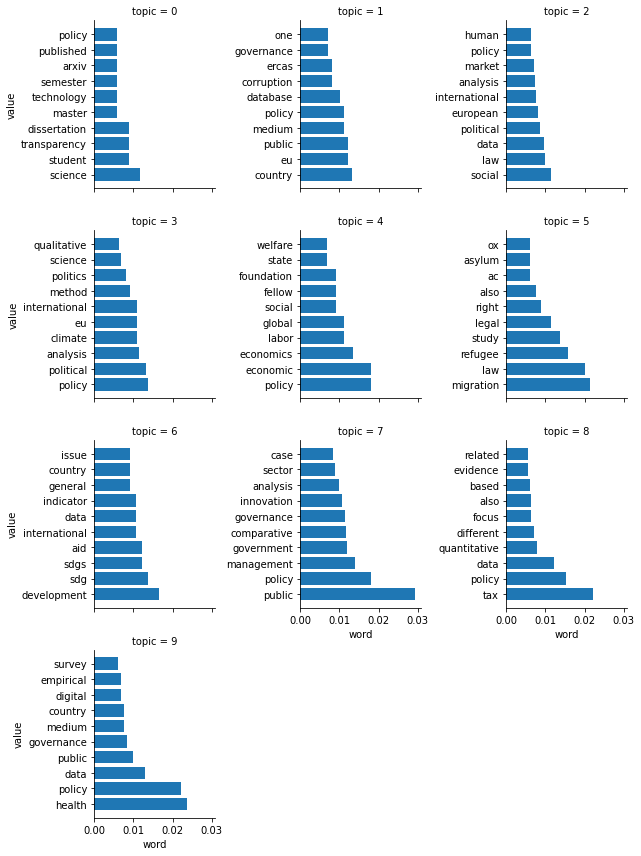

In [ ]:
# Visualize table above
g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

Using the **pyLDAvis** function, we can see the words that are most salient in each topic, as well as how topics can overlap in their use of relevant words.

On top of providing a good overview of how our LDA model associated words to topics, this interactive visualization tool helped us define the number of topics to input in the LDA model. Our aim is a good balance of precision and recall, to reach a reasonable coverage of the keywords that best represent ideas of research interests and research methodologies. 

In here, we have:
- Saliency: a measure of how much the term tells you about the topic.
- Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.

Finally, the size of the bubble measures the importance of the topics, relative to the data.

We also note that **gensim** starts indexing at 0 while **pyLDAvis** starts at 1. For instance, topic 1 in the graph equals topic 0 in our model. 

*This visulization does not show in GitHub. Colab notebooks works fine.*

In [ ]:
# Visualize model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_bow, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.085883 -0.042314       1        1   4.174211
1     -0.008843  0.064081       2        1   7.152288
2      0.075409 -0.050471       3        1  29.944177
3      0.095751 -0.092381       4        1  14.781919
4     -0.058600 -0.022349       5        1   1.803724
5     -0.135564 -0.058557       6        1   2.402596
6     -0.060873 -0.016578       7        1   3.955089
7      0.138815 -0.000007       8        1  17.292722
8     -0.027284  0.162495       9        1   8.143689
9      0.067071  0.056082      10        1  10.349584, topic_info=          Term        Freq       Total Category  logprob  loglift
525        law   37.000000   37.000000  Default  30.0000  30.0000
142     policy  124.000000  124.000000  Default  29.0000  29.0000
153     public   80.000000   80.000000  Default  28.0000  28.0000
1329    health   29.000000   29.000000  Default  27.0000  27.0000
962        tax   20.000000   20.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
292      focus    4.836658   36.034266  Topic10  -5.3699   0.2600
880    germany    4.043740   19.835991  Topic10  -5.5489   0.6779
425        use    4.043740   20.232453  Topic10  -5.5489   0.6581
10    analysis    4.836658   68.583206  Topic10  -5.3699  -0.3836
329       like    3.250821   10.883642  Topic10  -5.7672   1.0599

[763 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
202       1  0.765719            ab
203       1  0.330997          able
203       3  0.330997          able
203       4  0.330997          able
204       1  0.284412            ac
...     ...       ...           ...
442      10  0.175703           www
1772      7  0.529444           yet
201       4  0.838159          york
1639     10  0.650194         youth
1317      8  0.825210  öffentlichen

[1375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Now that we have mapped our topics, we check in each supervision plan what are the topics that are more prominent for that specific plan. The columns of the table `doc_id_dt` show the topic number (ranging from 0 to 9), followed by the probability of that plan being associated with said topic.

In [ ]:
# Topics per document in corpus
topics_doc_lda = lda_model[corpus_bow]

# Create table with doc_id and most prevalent topics per document
doc_id_dt = pd.DataFrame(topics_doc_lda )

# Supervisor names to index column
doc_id_dt.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

#doc_id_dt.columns = ['first_topic', 'second_topic']
#doc_id_dt.sort_values(['first_topic'], ascending=True, inplace=True)
doc_id_dt

,0,1
Anheier,"(3, 0.99679613)",None
Bryson,"(0, 0.99784654)",None
Cali,"(2, 0.99717766)",None
Cingolani,"(7, 0.99454385)",None
Costello,"(2, 0.13395265)","(5, 0.8631585)"
Dawson,"(2, 0.99594456)",None
Flachsland,"(3, 0.99764335)",None
GohdesHW,"(2, 0.9964967)",None
Graf,"(7, 0.9977151)",None
Hallerberg,"(7, 0.99710524)",None


And, for good measure, we check the probability of each topic being associated with each supervision plan. The results seem consistent with those shown in the previous table.

In [ ]:
# Topic probabilities per document
topics = [lda_model[corpus_bow[i]] for i in range(len(corpus))]
num_topics = 10

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

# Supervisor names to index column
document_topic.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

document_topic # table with topic probabilities per document

,0,1,2,3,4,5,6,7,8,9
Anheier,0.000000,0.000000,0.000000,0.996796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bryson,0.997847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cali,0.000000,0.000000,0.997178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cingolani,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994544,0.000000,0.000000
Costello,0.000000,0.000000,0.133953,0.000000,0.000000,0.863158,0.000000,0.000000,0.000000,0.000000
Dawson,0.000000,0.000000,0.995944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Flachsland,0.000000,0.000000,0.000000,0.997643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GohdesHW,0.000000,0.000000,0.996497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Graf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997715,0.000000,0.000000
Hallerberg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997105,0.000000,0.000000


### User Query - LDA
All of the previous steps concern our topic modeling choices to establish a model to apply to students' research proposals. As such, we don't expect the final user to have access to - or even be aware of - what goes on "under the hood" of our Supervisor Recommendation Tool.

In these next lines, we apply the `lda_model` to a given students' Master Thesis Proposal. Here, the user must provide some input: the content of their research proposal. 

We experimented two alternative forms of getting this input:
- Add text (`ud_text`) allows for students to copy and paste the text of their proposal; and
- Add Document(`ud_path`) allows for students to provide for a local path where the research proposal is saved, in txt format.





In [ ]:
#@title Add Text { run: "auto", vertical-output: true }

ud_text = "health inequality" #@param {type:"string"}



In [ ]:
#@title Add Document
path = "/content/drive/My Drive/docs/ana.txt" #@param {type:"string"}
ud_p = open(path)
ud_path = ud_p.read()

First we tokenize the text. Then, we apply the **WordNet** lemmatizer to the text. We have to re-tokenize the lemmatized string from `ud_lemma`. Finally, we apply the dictionary to generate a bag-of-words. 

An important note: there's no need to apply the `filter_token` function here because the model makes the comparison using only words that were contained in the original bag-of-words (`corpus_bow`). 

In [ ]:
# Tokenize and create bag of words for unseen document
ud_tokens = nltk.word_tokenize(ud_path) 
ud_lemma = ' '.join([wordnet.lemmatize(token) for token in ud_tokens]) # ud can be either `ud_text` or `ud_path`
ud_tk_lemma = nltk.word_tokenize(ud_lemma) 
ud_bow_vector = dictionary.doc2bow(ud_tk_lemma)

We find the three topics that are most prominently associated with the student's research proposal (as transformed in the bag-of-words). 

In [ ]:
# Table with proximity score for top three topics related to unseen doc
results = pd.DataFrame(lda_model[ud_bow_vector])
results.columns = ['topic', 'proximity']
results.sort_values(['proximity'], ascending=False, inplace=True)
print(results.nlargest(3,['proximity']))

   topic  proximity
2      2   0.413587
1      1   0.149519
6      7   0.108667


Our next step is to display a list of the top 10  more frequent words in each of the topics indicated by our model to be the best matches for their proposal.

In [ ]:
# Presenting results to user as a list of words based on `results` table
results_dt = pd.DataFrame(results.nlargest(3,['proximity']))

# Transform top three topics into variables 
first_choice = int(results_dt.iloc[0]['topic'])
second_choice = int(results_dt.iloc[1]['topic'])
third_choice = int(results_dt.iloc[2]['topic'])

# First topic top words table with `first_choice`
words1 = pd.DataFrame(topic_words[topic_words['topic'] == first_choice])

# Second topic
words2 = pd.DataFrame(topic_words[topic_words['topic'] == second_choice])

# Third topic
words3 = pd.DataFrame(topic_words[topic_words['topic'] == third_choice])

# Create table containing all three lists of words
all_words = pd.concat([words1, words2, words3], ignore_index=True)
#all_words = pd.concat([words1, words2], ignore_index=True)

# Pivot table 
pivot_table = all_words.pivot_table(index=None,
                                     columns='topic', 
                                     values='word',
                                     aggfunc=lambda x: ', '.join(x))

print("Our model indicates that topics " ,first_choice,', ',second_choice, " and " ,third_choice, " are the best matches to your research proposal!\nHere is a list of some of the words most frequently associated with these topics:\n", sep = '')
pivot_table

Our model indicates that topics 2, 1 and 7 are the best matches to your research proposal!
Here is a list of some of the words most frequently associated with these topics:



topic,1,2,7
word,"country, eu, public, medium, policy, database,...","social, law, data, political, european, intern...","public, policy, management, government, compar..."


As a way to allow for students to choose what is most relevant for them -- for example, if faced with a choice of which to prioritize, a particular methodological approach or a substantive research interest -- we ask them, based on the sample of words we provided, to choose which of the three topics best relates to their research.

In [ ]:
#@title Which topic best relates to your research?

ud_topic_input = 2 #@param {type:"integer"}

# Prompt user to choose among 3 topics based on 10 top words per topic table [`words1`, `words3` or `words3`]

Based on the student's choice, the system provides a list of the supervisors better suited to the student's research proposal.

In [ ]:
ud_recommend = pd.DataFrame(document_topic.sort_values(ud_topic_input, ascending=False)[ud_topic_input]).head(5)  # from document_topic table
ud_recommend.columns = ['prob']
ud_recommend = ud_recommend[ud_recommend.prob > 0]
print(*ud_recommend.index.tolist(), sep='\n')

Hirth
Munzert
Cali
GohdesHW
Dawson


## TF-IDF Model

Here we use the Term Frequency-Inverse Document Frequency (TD-IDF) model from **gensim** to assess whether it provides better recommendations. 

TF-IDF is a statistical measure that evaluates how relevant a word is to a corpus  by measuring word frequency in a document and the inverse document frequency of the same word across the corpus. The same visualizations and comparison used before are displayed.


In [ ]:
"""
The same data from the *Data* section is used here. 
"""
# Create bag of words for each document
bow_tdidf = models.TfidfModel(corpus_bow) # same bow from lda_model, converted to tf-idf
corpus_tfidf = bow_tdidf[corpus_bow] # final bow for tf-idf model -- equates `corpus_bow` for lda_model

In [ ]:
# Run model
tfidf_model= gensim.models.LdaMulticore(corpus_tfidf, 
                                         id2word=dictionary,
                                         num_topics=6, 
                                         random_state=123, 
                                         passes=500)

### TF-IDF Visualization

In [ ]:
# Visualize words per topic
for i, topic in enumerate(tfidf_model.print_topics(num_topics=10, num_words=7)):
    print (i, ':', topic)

0 : (0, '0.002*"public" + 0.001*"digital" + 0.001*"management" + 0.001*"law" + 0.001*"electricity" + 0.001*"smart" + 0.001*"government"')
1 : (1, '0.001*"lab" + 0.001*"ercas" + 0.001*"monitoring" + 0.001*"client" + 0.001*"database" + 0.001*"report" + 0.001*"trust"')
2 : (2, '0.001*"corporate" + 0.001*"organizational" + 0.001*"bit" + 0.001*"organization" + 0.001*"sage" + 0.001*"security" + 0.001*"labor"')
3 : (3, '0.001*"climate" + 0.001*"law" + 0.001*"sdg" + 0.001*"mair" + 0.001*"right" + 0.001*"aid" + 0.001*"international"')
4 : (4, '0.001*"educational" + 0.001*"education" + 0.001*"politics" + 0.001*"campaigning" + 0.001*"submit" + 0.001*"willing" + 0.001*"training"')
5 : (5, '0.002*"health" + 0.001*"migration" + 0.001*"labour" + 0.001*"tax" + 0.001*"law" + 0.001*"family" + 0.001*"ministry"')


In [ ]:
# Create table with top 10 words per topic
n_words = 10
topic_words = pd.DataFrame({})

for i, topic in enumerate(tfidf_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

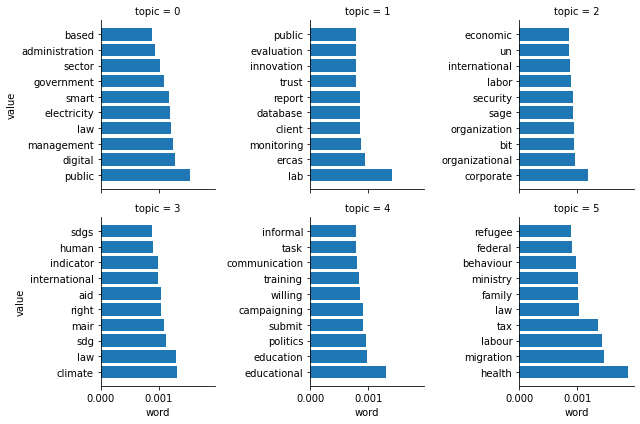

In [ ]:
# Visualize table above
g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

In [ ]:
# Visualize model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(tfidf_model, corpus_tfidf, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.007966  0.002339       1        1  26.513480
1      0.000207 -0.000022       2        1   8.407257
2      0.001015 -0.005351       3        1  19.037141
3      0.001609 -0.002076       4        1  16.895208
4      0.000436 -0.000796       5        1   9.605368
5      0.004699  0.005907       6        1  19.541546, topic_info=             Term      Freq     Total Category  logprob  loglift
1188          lab  0.000000  0.000000  Default  30.0000  30.0000
1329       health  0.000000  0.000000  Default  29.0000  29.0000
1083  educational  0.000000  0.000000  Default  28.0000  28.0000
322        labour  0.000000  0.000000  Default  27.0000  27.0000
2046        ercas  0.000000  0.000000  Default  26.0000  26.0000
...           ...       ...       ...      ...      ...      ...
1120       market  0.050062  0.186591   Topic6  -7.2005   0.3170
1104   inequality  0.048754  0.171139   Topic6  -7.2270   0.3769
45           data  0.049437  0.184559   Topic6  -7.2131   0.3154
493      european  0.049333  0.189637   Topic6  -7.2152   0.2861
52      economics  0.048541  0.181505   Topic6  -7.2314   0.3138

[284 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [ ]:
# Topics per document in corpus
topics_doc_tfidf = tfidf_model[corpus_tfidf]

# Create table with doc_id and most prevalent topics per document
doc_id_dt = pd.DataFrame(topics_doc_tfidf)

# Supervisor names to index column
doc_id_dt.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

#doc_id_dt.columns = ['first_topic', 'second_topic']
#doc_id_dt.sort_values(['first_topic'], ascending=True, inplace=True)
doc_id_dt

,0,1,2,3,4,5
Anheier,"(0, 0.012394645)","(1, 0.012351389)","(2, 0.012403434)","(3, 0.9381119)","(4, 0.012362696)","(5, 0.012375932)"
Bryson,"(0, 0.9436109)","(1, 0.011263384)","(2, 0.011279764)","(3, 0.011271658)","(4, 0.011273022)","(5, 0.0113012735)"
Cali,"(0, 0.014994364)","(1, 0.014923253)","(2, 0.014999211)","(3, 0.92512006)","(4, 0.014942863)","(5, 0.015020227)"
Cingolani,"(0, 0.92297)","(1, 0.01539054)","(2, 0.015428686)","(3, 0.015404818)","(4, 0.015394341)","(5, 0.01541161)"
Costello,"(0, 0.015331617)","(1, 0.015261748)","(2, 0.015303629)","(3, 0.015364386)","(4, 0.015269417)","(5, 0.9234692)"
Dawson,"(0, 0.91139054)","(1, 0.017670585)","(2, 0.017716328)","(3, 0.017752737)","(4, 0.017681839)","(5, 0.017787952)"
Flachsland,"(0, 0.012287226)","(1, 0.012173059)","(2, 0.012215424)","(3, 0.9388929)","(4, 0.012199193)","(5, 0.012232199)"
GohdesHW,"(0, 0.012559926)","(1, 0.012511164)","(2, 0.9372846)","(3, 0.01254604)","(4, 0.012530324)","(5, 0.0125679895)"
Graf,"(0, 0.013742562)","(1, 0.013609786)","(2, 0.013700688)","(3, 0.013704052)","(4, 0.9315196)","(5, 0.013723349)"
Hallerberg,"(0, 0.014483524)","(1, 0.9280875)","(2, 0.014355858)","(3, 0.014374305)","(4, 0.014339527)","(5, 0.014359283)"


In [ ]:
# Topic probabilities per document
topics = [tfidf_model[corpus_bow[i]] for i in range(len(corpus))]
num_topics = 6

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

# Supervisor names to index column
document_topic.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

document_topic # table with topic probabilities per document

,0,1,2,3,4,5
Anheier,0.000000,0.000000,0.000000,0.996996,0.000000,0.000000
Bryson,0.997985,0.000000,0.000000,0.000000,0.000000,0.000000
Cali,0.000000,0.000000,0.000000,0.997351,0.000000,0.000000
Cingolani,0.994922,0.000000,0.000000,0.000000,0.000000,0.000000
Costello,0.000000,0.000000,0.000000,0.000000,0.000000,0.996955
Dawson,0.996214,0.000000,0.000000,0.000000,0.000000,0.000000
Flachsland,0.129350,0.000000,0.000000,0.868882,0.000000,0.000000
GohdesHW,0.000000,0.000000,0.996723,0.000000,0.000000,0.000000
Graf,0.205053,0.000000,0.011768,0.000000,0.731339,0.041698
Hallerberg,0.281007,0.716820,0.000000,0.000000,0.000000,0.000000


### User Query - TF-IDF



In [ ]:
#@title Add Text { run: "auto", vertical-output: true }

ud_text = "health inequality" #@param {type:"string"}



In [ ]:
#@title Add Document
path = "/content/drive/My Drive/docs/ana.txt" #@param {type:"string"}
ud_p = open(path)
ud_path = ud_p.read()

In [ ]:
# Tokenize and create bag of words for unseen document
ud_tokens = nltk.word_tokenize(ud_path) 
ud_lemma = ' '.join([wordnet.lemmatize(token) for token in ud_tokens]) # ud can be either `ud_text` or `ud_path`
ud_tk_lemma = nltk.word_tokenize(ud_lemma) 
ud_bow_vector = dictionary.doc2bow(ud_tk_lemma)

In [ ]:
# Table with proximity score for top three topics related to unseen doc
results = pd.DataFrame(tfidf_model[ud_bow_vector])
results.columns = ['topic', 'proximity']
results.sort_values(['proximity'], ascending=False, inplace=True)
print(results.nlargest(3,['proximity']))

   topic  proximity
0      0   0.618628
2      5   0.195941
1      3   0.183209


In [ ]:
# Presenting results to user as a list of words based on `results` table
results_dt = pd.DataFrame(results.nlargest(3,['proximity']))

# Transform top three topics into variables 
first_choice = int(results_dt.iloc[0]['topic'])
second_choice = int(results_dt.iloc[1]['topic'])
third_choice = int(results_dt.iloc[2]['topic'])

# First topic top words table with `first_choice`
words1 = pd.DataFrame(topic_words[topic_words['topic'] == first_choice])


# Second topic
words2 = pd.DataFrame(topic_words[topic_words['topic'] == second_choice])


# Third topic
words3 = pd.DataFrame(topic_words[topic_words['topic'] == third_choice])


# Create table containing all three lists of words
all_words = pd.concat([words1, words2, words3], ignore_index=True)

# Pivot table 
pivot_table = all_words.pivot_table(index=None,
                                     columns='topic', 
                                     values='word',
                                     aggfunc=lambda x: ', '.join(x))

print("Our model indicates that topics " ,first_choice,', ',second_choice, " and " ,third_choice, " are the best matches to your research proposal!\nHere is a list of some of the words most frequently associated with these topics:\n", sep = '')
#print(words1.title(), words2.title(), words3.title(), sep='\n')
pivot_table

Our model indicates that topics 0, 5 and 3 are the best matches to your research proposal!
Here is a list of some of the words most frequently associated with these topics:



topic,0,3,5
word,"public, digital, management, law, electricity,...","climate, law, sdg, mair, right, aid, internati...","health, migration, labour, tax, law, family, m..."


In [ ]:
#@title Which topic best relates to your research?

ud_topic_input = 0 #@param {type:"integer"}

# Prompt user to choose among 3 topics based on 10 top words per topic table [`words1`, `words3` or `words3`]

In [ ]:
ud_recommend = pd.DataFrame(document_topic.sort_values(ud_topic_input, ascending=False)[ud_topic_input]).head(5)  # from document_topic table
ud_recommend.columns = ['prob']
ud_recommend = ud_recommend[ud_recommend.prob > 0]
print(*ud_recommend.index.tolist(), sep='\n')

Hirth
Stockman
Bryson
Hammerschmid
Kayser
